# C S 342 Final Project

## Overview

**Problem/Solution**

The project involves building a neural network to classify hand gestures from American Sign Language (ASL), specifically focusing on the 24 letters of the ASL alphabet (excluding J and Z, as they involve movement). The model aims to facilitate sign language recognition, which can enable individuals to communicate with technology or other people using sign language. Additionally, it could be expanded into touchless human-computer interactions, such as controlling devices or applications through hand gestures.

 **Training Data**

The training data will be sourced from the ~~Sign Language MNIST dataset~~, ASL Alphabet Dataset which contains ~~grayscale 28x28 pixel~~ 200x200 pixel color images of hand gestures representing the 24 letters of the ASL alphabet and labeled with the corresponding ASL letter. ~~The dataset was created by extending a small set of 1,704 uncropped color images. These images were then cropped around the hand region, converted to grayscale, resized, and augmented with over 50 variations per image using filters, random pixelation, brightness/contrast adjustments, and slight rotations. The final dataset includes 27,455 training images and 7,172 test images.~~


**Computational experiments**

Experiment 1 is an ablation study, where we remove or modify different parts of the model (e.g., regularization techniques, CNN layers, dropout, activation functions) to identify which components are most crucial for accurately classifying hand gestures. The goal is to better understand how the model differentiates between gestures and to find any critical features or architectural choices that improve classification performance.

Experiment 2 is a generalization study, in which the model trained on the Sign Language MNIST dataset will be evaluated on a different hand gesture dataset to test its ability to generalize and check for overfitting. If time permits, this experiment will also include testing the model in a real-time setting, where it classifies gestures from processed images captured via a camera feed.


## Loading and Understanding the Dataset

In [467]:
# Standard library
import random
from collections import Counter, defaultdict

# Numerical and data tools
import numpy as np

# PyTorch core
import torch
import torch.nn as nn
import torch.optim as optim

# PyTorch utilities
from torch.utils.data import DataLoader, random_split, Subset

# TorchVision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Scikit-learn metrics
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

# Progress bar
from tqdm import tqdm


In [343]:
# Define training and evaluation data transforms

train_transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),             
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

eval_transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
])

In [344]:
# Load dataset twice for train and eval

data_dir = "ASL Alphabet Dataset"
train_full = ImageFolder(root=data_dir, transform=train_transform)
eval_full = ImageFolder(root=data_dir, transform=eval_transform)
print("Classes:", train_full.classes)
print("Total images:", len(train_full))

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
Total images: 166028


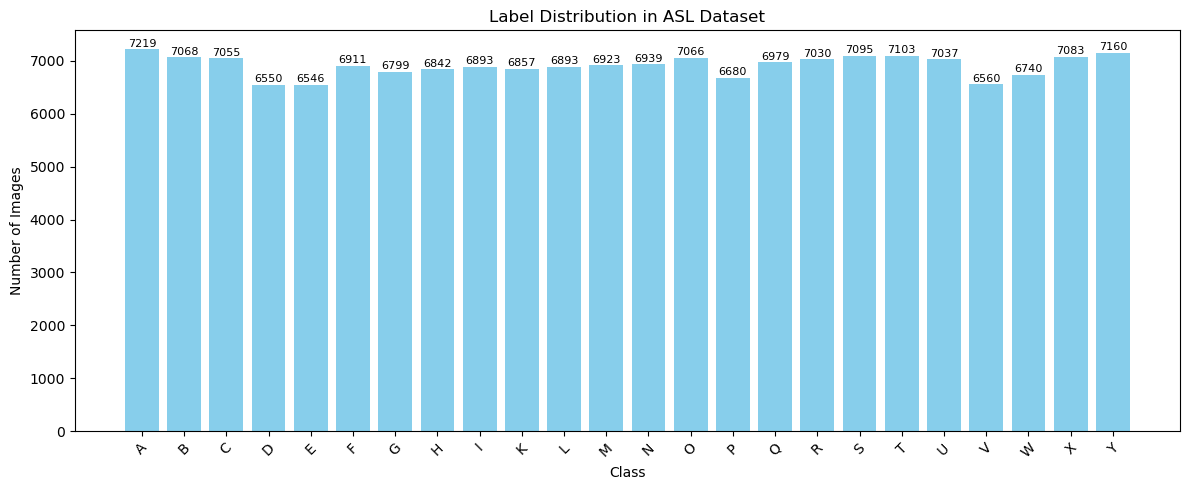

In [345]:
# Plot dataset class distribution

label_counts = Counter(train_full.targets)
counts = list(label_counts.values())
classes = [train_full.classes[i] for i in label_counts.keys()]

plt.figure(figsize=(12, 5))
bars = plt.bar(classes, counts, color="skyblue")
plt.title("Label Distribution in ASL Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 10, str(height),
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [346]:
# Split dataset into train, validation, and test sets

train_size = int(0.7 * len(train_full))
val_size = int(0.15 * len(train_full))
test_size = len(train_full) - train_size - val_size

train_ds, val_ds, test_ds = random_split(
    train_full, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

val_ds = Subset(eval_full, val_ds.indices)
test_ds = Subset(eval_full, test_ds.indices)

In [347]:
# Create DataLoaders

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)


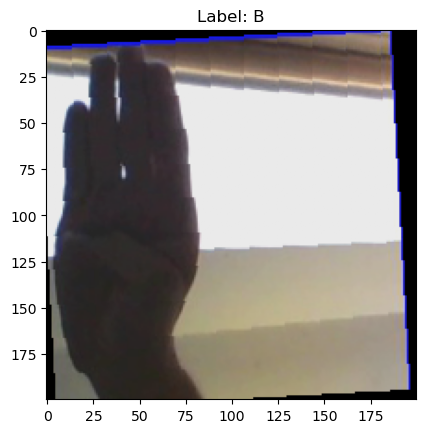

In [348]:
# Show a sample image

def imshow(img, title=""):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.title(title)
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(images[0], title=f"Label: {train_full.classes[labels[0]]}")

## Training the Model

In [349]:
# Set device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [350]:
# Define training function

def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0

    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / len(dataloader.dataset)
    return epoch_loss, epoch_acc

In [402]:
# Define validation / testing function

def evaluate(model, dataloader, criterion, return_preds=False):
    model.eval()
    running_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()

            if return_preds:
                all_preds.append(preds.cpu())
                all_labels.append(labels.cpu())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / len(dataloader.dataset)

    if return_preds:
        return epoch_loss, epoch_acc, torch.cat(all_preds), torch.cat(all_labels)
    else:
        return epoch_loss, epoch_acc


In [ ]:
# Define evaluation function with detailed output

def evaluate(model, dataloader, criterion, return_preds=False, num_classes=None):
    model.eval()
    running_loss = 0.0
    correct = 0

    all_preds = []
    all_labels = []
    all_outputs = []
    all_inputs = []

    correct_samples = {}

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()

            if return_preds:
                all_preds.append(preds.cpu())
                all_labels.append(labels.cpu())
                all_outputs.append(outputs.cpu())

                for i in range(len(preds)):
                    image = inputs[i].cpu()
                    pred = preds[i].item()
                    label = labels[i].item()
                    entry = {'image': image, 'true_label': label, 'predicted_label': pred}

                    if pred != label:
                        all_inputs.append(entry)
                    else:
                        if label not in correct_samples:
                            correct_samples[label] = entry

    all_inputs.extend(correct_samples.values())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / len(dataloader.dataset)

    if return_preds:
        return (
            epoch_loss,
            epoch_acc,
            torch.cat(all_preds),
            torch.cat(all_labels),
            torch.cat(all_outputs),
            all_inputs
        )
    else:
        return epoch_loss, epoch_acc


In [ ]:
# Plots the per class accuracy 

def plot_per_class_accuracy(preds, labels, class_names):
    num_classes = len(class_names)
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    for i in range(len(labels)):
        label = labels[i].item()
        pred = preds[i].item()
        class_total[label] += 1
        if pred == label:
            class_correct[label] += 1

    class_accuracy = [correct / total if total > 0 else 0.0
                      for correct, total in zip(class_correct, class_total)]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(num_classes), class_accuracy, color='skyblue')
    plt.xticks(range(num_classes), class_names, rotation=45, ha='right')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.1)

    ticks = plt.yticks()[0]
    plt.yticks([t for t in ticks if t <= 1.0])

    plt.title('Per-Class Accuracy')

    for bar, acc in zip(bars, class_accuracy):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
                 f"{acc:.2f}", ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()


In [ ]:
# Plots the confusion matrix with both linear and log scale

def get_confusion_matrix(preds, labels, class_names):
    cm = confusion_matrix(labels, preds, labels=list(range(len(class_names))))
    return cm

def plot_confusion_matrices(cm, class_names, normalize=False, figsize=(20, 8)):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], cbar=True)
    axes[0].set_title("Confusion Matrix (Linear Scale)")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")
    axes[0].tick_params(axis='x', rotation=45)

    masked_cm = np.ma.masked_where(cm == 0, cm)
    log_norm = mcolors.LogNorm(vmin=max(masked_cm.min(), 1e-1), vmax=masked_cm.max())

    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], norm=log_norm, cbar=True)
    axes[1].set_title("Confusion Matrix (Log Scale)")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


In [ ]:
# Prints per class precision, recall, and f1-score

def evaluate_precision_recall_f1(preds, labels, num_classes):
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    # precision = precision_score(labels, preds, average=None, labels=np.arange(num_classes))
    # recall = recall_score(labels, preds, average=None, labels=np.arange(num_classes))
    # f1 = f1_score(labels, preds, average=None, labels=np.arange(num_classes))
    
    print("\nClassification Report:\n", classification_report(labels, preds))


In [ ]:
# Shows the most common misclassified pairs with correct images on each side

def track_misclassifications(preds, labels, inputs, top_n=5):
    misclassified = []
    
    for i in range(len(preds)):
        if preds[i] != labels[i]:
            misclassified.append({
                'true_label': labels[i].item(),
                'predicted_label': preds[i].item(),
                'image': inputs[i]
            })
    
    return misclassified

def get_top_n_misclassified_pairs(misclassified, top_n=5):
    misclassification_pairs = [(entry['true_label'], entry['predicted_label']) for entry in misclassified]
    pair_counts = Counter(misclassification_pairs)
    top_n_pairs = pair_counts.most_common(top_n)
    return top_n_pairs

def plot_misclassified_vs_correct(top_n_pairs, misclassified, all_images, class_names, n=5):
    fig, axes = plt.subplots(n, 3, figsize=(12, 4 * n))

    for i in range(n):
        (true_label, predicted_label), _ = top_n_pairs[i]
        ax_row = axes[i]

        pred_corr = next((x for x in all_images 
                          if x['true_label'] == predicted_label and x['predicted_label'] == predicted_label), None)
        mis = next((x for x in misclassified 
                    if x['true_label'] == true_label and x['predicted_label'] == predicted_label), None)

        true_corr = next((x for x in all_images 
                          if x['true_label'] == true_label and x['predicted_label'] == true_label), None)

        if pred_corr is not None:
            img = pred_corr['image'].cpu().numpy().transpose((1, 2, 0))
            ax_row[0].imshow(img)
            ax_row[0].set_title(f"Correct: {class_names[predicted_label]}")
            ax_row[0].axis('off')
        else:
            ax_row[0].set_visible(False)

        if mis is not None:
            img = mis['image'].cpu().numpy().transpose((1, 2, 0))
            ax_row[1].imshow(img)
            ax_row[1].set_title(f"Misclassified: Pred {class_names[predicted_label]} / True {class_names[true_label]}")
            ax_row[1].axis('off')
        else:
            ax_row[1].set_visible(False)

        if true_corr is not None:
            img = true_corr['image'].cpu().numpy().transpose((1, 2, 0))
            ax_row[2].imshow(img)
            ax_row[2].set_title(f"Correct: {class_names[true_label]}")
            ax_row[2].axis('off')
        else:
            ax_row[2].set_visible(False)

    plt.tight_layout()
    plt.show()

In [410]:
# Define our model

class ASLCNN(nn.Module):
    def __init__(self, num_classes):
        super(ASLCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),  # (32, 100, 100)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),  # (64, 50, 50)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),  # (128, 25, 25)

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),  # (256, 12, 12)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 12 * 12, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [411]:
# Instantiate training parameters 

model = ASLCNN(num_classes=len(train_full.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [354]:
# Train and save best model

epochs = 10
best_val_acc = 0.0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Saved new best model.")



Epoch 1/10


100%|██████████| 3632/3632 [04:49<00:00, 12.55it/s]


Train Loss: 2.7255, Train Acc: 0.1422
Val   Loss: 1.5779, Val   Acc: 0.4462
✅ Saved new best model.

Epoch 2/10


100%|██████████| 3632/3632 [04:58<00:00, 12.18it/s]


Train Loss: 1.2992, Train Acc: 0.5457
Val   Loss: 0.4799, Val   Acc: 0.8327
✅ Saved new best model.

Epoch 3/10


100%|██████████| 3632/3632 [04:49<00:00, 12.54it/s]


Train Loss: 0.6175, Train Acc: 0.7912
Val   Loss: 0.2022, Val   Acc: 0.9367
✅ Saved new best model.

Epoch 4/10


100%|██████████| 3632/3632 [04:48<00:00, 12.57it/s]


Train Loss: 0.3891, Train Acc: 0.8721
Val   Loss: 0.1496, Val   Acc: 0.9534
✅ Saved new best model.

Epoch 5/10


100%|██████████| 3632/3632 [05:15<00:00, 11.51it/s]


Train Loss: 0.2904, Train Acc: 0.9062
Val   Loss: 0.0875, Val   Acc: 0.9741
✅ Saved new best model.

Epoch 6/10


100%|██████████| 3632/3632 [05:10<00:00, 11.72it/s]


Train Loss: 0.2380, Train Acc: 0.9250
Val   Loss: 0.0998, Val   Acc: 0.9682

Epoch 7/10


100%|██████████| 3632/3632 [05:00<00:00, 12.07it/s]


Train Loss: 0.1998, Train Acc: 0.9376
Val   Loss: 0.1021, Val   Acc: 0.9674

Epoch 8/10


100%|██████████| 3632/3632 [04:56<00:00, 12.24it/s]


Train Loss: 0.1806, Train Acc: 0.9437
Val   Loss: 0.0424, Val   Acc: 0.9872
✅ Saved new best model.

Epoch 9/10


100%|██████████| 3632/3632 [04:54<00:00, 12.31it/s]


Train Loss: 0.1654, Train Acc: 0.9507
Val   Loss: 0.0407, Val   Acc: 0.9883
✅ Saved new best model.

Epoch 10/10


100%|██████████| 3632/3632 [04:51<00:00, 12.45it/s]


Train Loss: 0.1503, Train Acc: 0.9552
Val   Loss: 0.0671, Val   Acc: 0.9815


C:\Users\ExoHorizon\AppData\Local\Temp\ipykernel_36652\902997566.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
C:\U

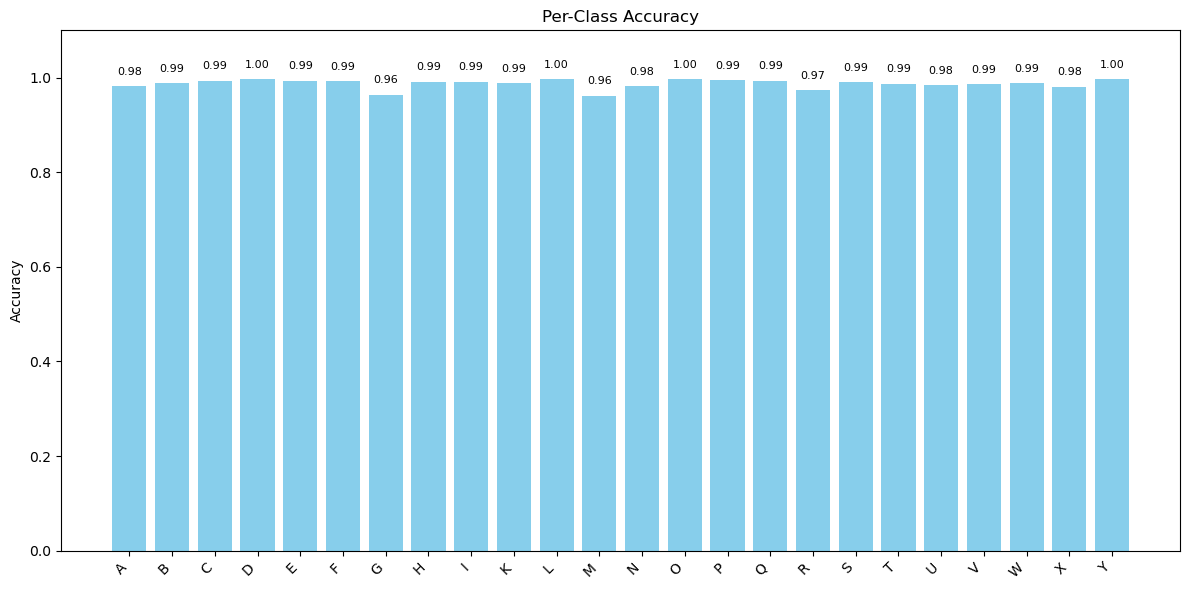

Test Loss: 0.0402, Test Accuracy: 0.9872


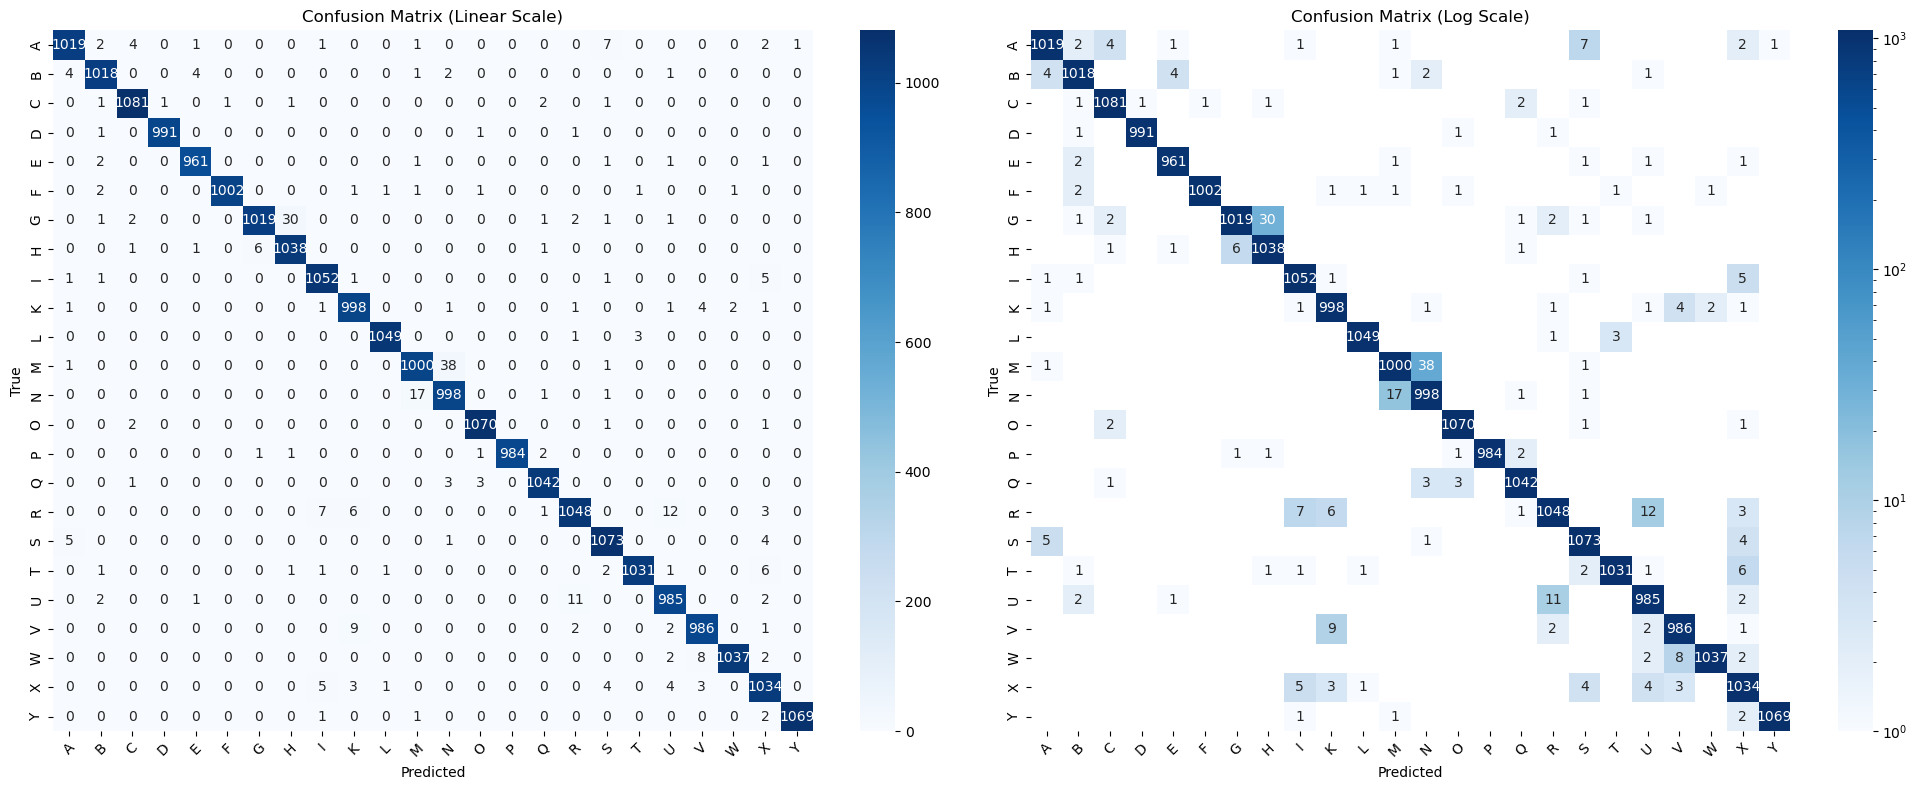


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1038
           1       0.99      0.99      0.99      1030
           2       0.99      0.99      0.99      1088
           3       1.00      1.00      1.00       994
           4       0.99      0.99      0.99       967
           5       1.00      0.99      1.00      1010
           6       0.99      0.96      0.98      1057
           7       0.97      0.99      0.98      1047
           8       0.99      0.99      0.99      1061
           9       0.98      0.99      0.98      1010
          10       1.00      1.00      1.00      1053
          11       0.98      0.96      0.97      1040
          12       0.96      0.98      0.97      1017
          13       0.99      1.00      1.00      1074
          14       1.00      0.99      1.00       989
          15       0.99      0.99      0.99      1049
          16       0.98      0.97      0.98      1077
  

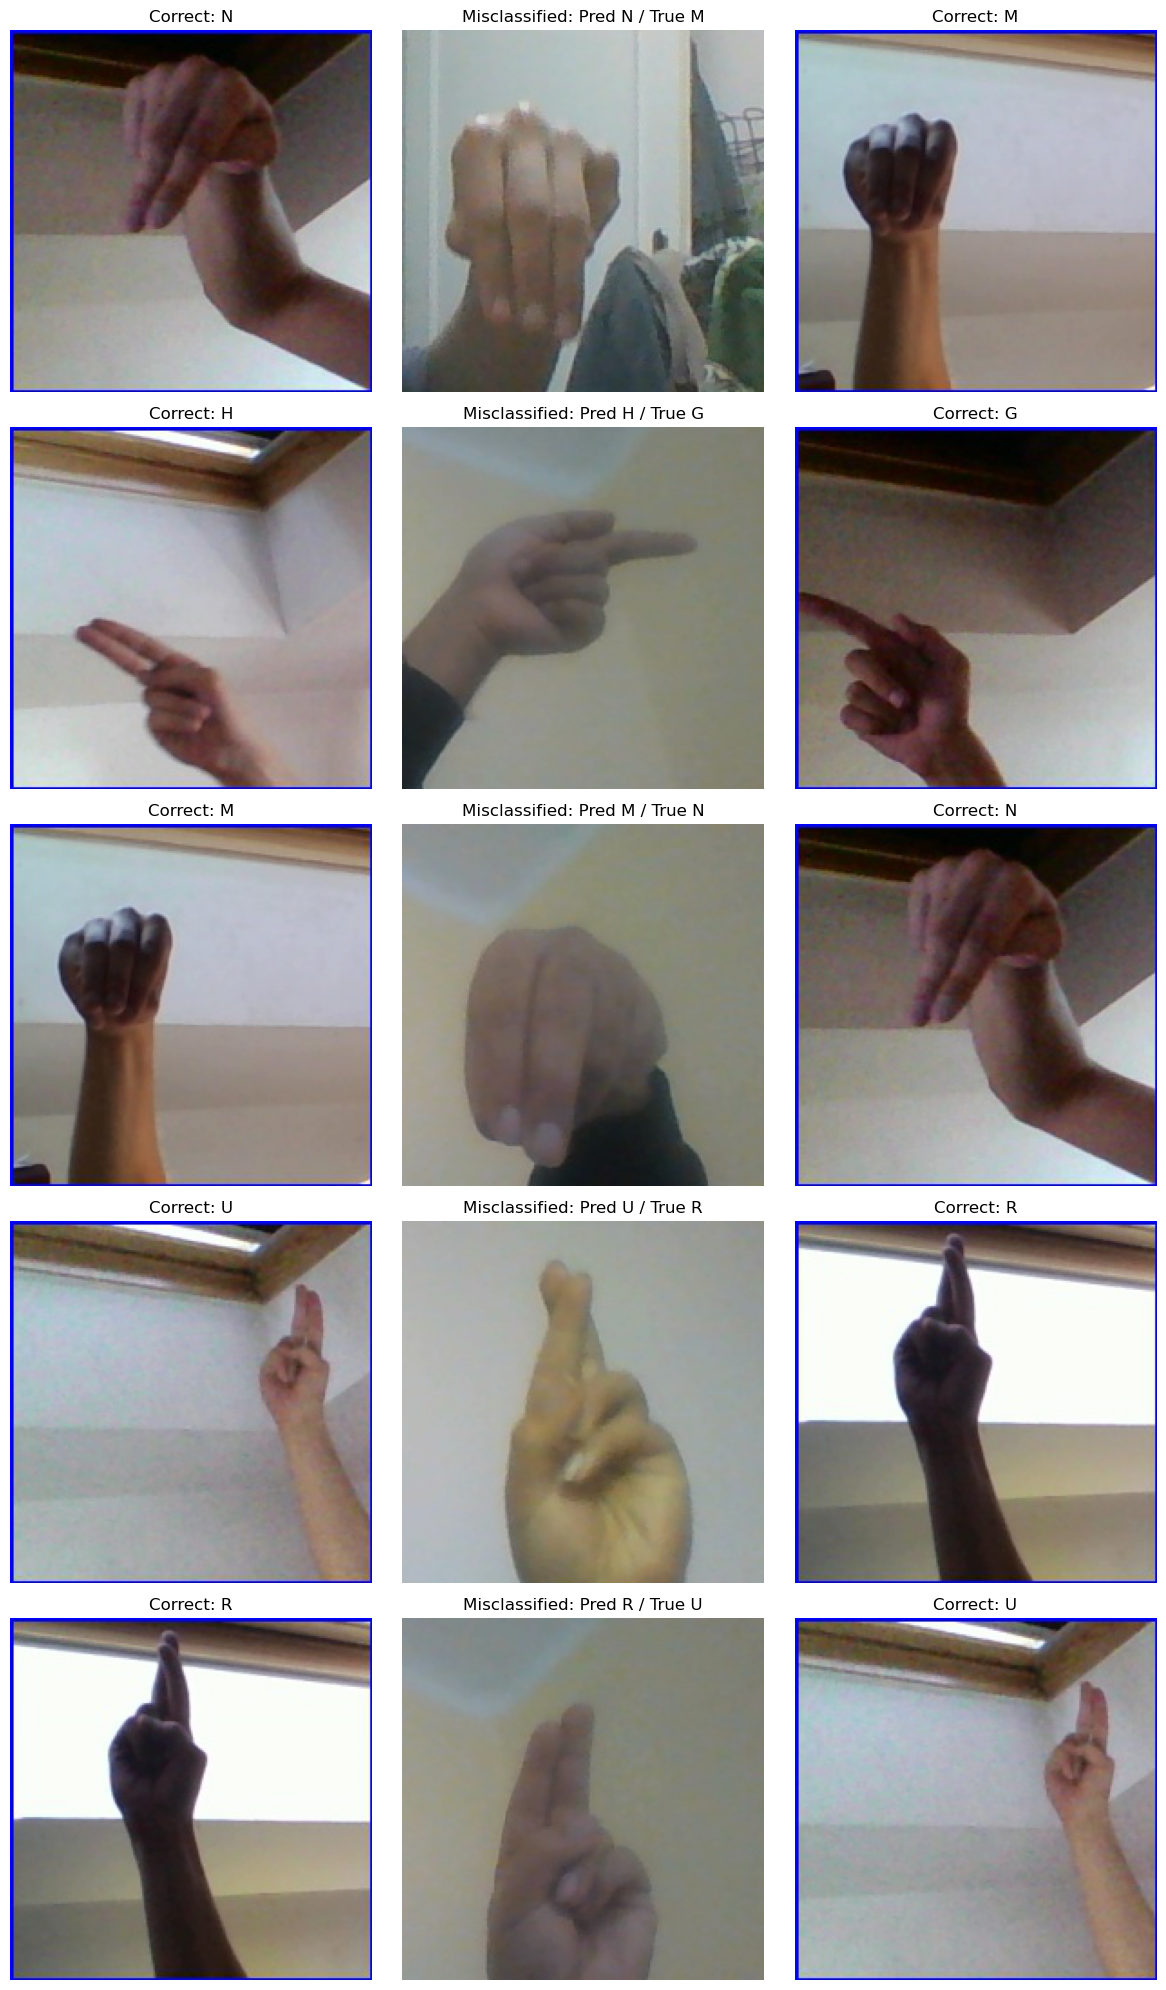

In [ ]:
# Evaluate the model on the test set

class_names = train_full.classes
model.load_state_dict(torch.load("best_model.pth", map_location=device, weights_only=True))

test_loss, test_acc, preds, labels, outputs, inputs = evaluate(model, test_loader, criterion, return_preds=True)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

plot_per_class_accuracy(preds, labels, class_names)

cm = get_confusion_matrix(preds, labels, class_names)
plot_confusion_matrices(cm, class_names, normalize=False)

evaluate_precision_recall_f1(preds, labels, num_classes=len(class_names))

misclassified = [x for x in inputs if x['true_label'] != x['predicted_label']]
top_n_pairs = get_top_n_misclassified_pairs(misclassified, top_n=5)
plot_misclassified_vs_correct(top_n_pairs, misclassified, inputs, class_names, n=5)

## Experiment 1: Generalization Study

In [ ]:
# Set seed for reproducibility
random.seed(42)

# Define your transform
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
])

# Step 1: Load dataset WITHOUT transform (faster label access)
temp_dataset = datasets.ImageFolder(root="Generalizability Dataset\\ASL_Dataset\\Train")

# Step 2: Group indices by class using label info
class_indices = defaultdict(list)
for idx, (_, label) in enumerate(temp_dataset.imgs):  # Access labels directly
    class_indices[label].append(idx)

# Step 3: Randomly sample up to 1000 indices per class
selected_indices = []
for label, indices in class_indices.items():
    sampled = random.sample(indices, min(1000, len(indices)))
    selected_indices.extend(sampled)

# Step 4: Reload the full dataset WITH transforms
new_dataset = datasets.ImageFolder(
    root="Generalizability Dataset\\ASL_Dataset\\Train",
    transform=transform
)

# Step 5: Create subset and DataLoader
subset_dataset = Subset(new_dataset, selected_indices)
new_loader = DataLoader(subset_dataset, batch_size=32, shuffle=False)

# Step 6: Confirm results
print("Classes:", new_dataset.classes)
print("Subset total images:", len(subset_dataset))

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
Subset total images: 24000


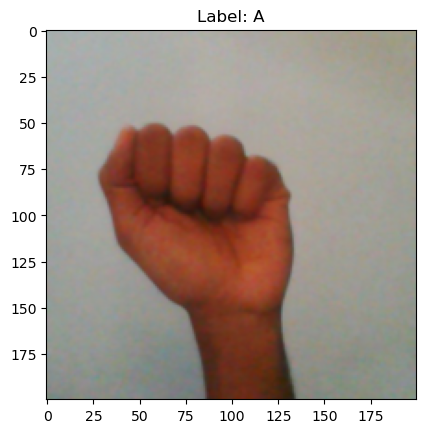

In [456]:
# Show a sample image from new dataset

dataiter = iter(new_loader)
images, labels = next(dataiter)
imshow(images[0], title=f"Label: {new_dataset.classes[labels[0]]}")

C:\Users\ExoHorizon\AppData\Local\Temp\ipykernel_36652\2970565309.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
C:\

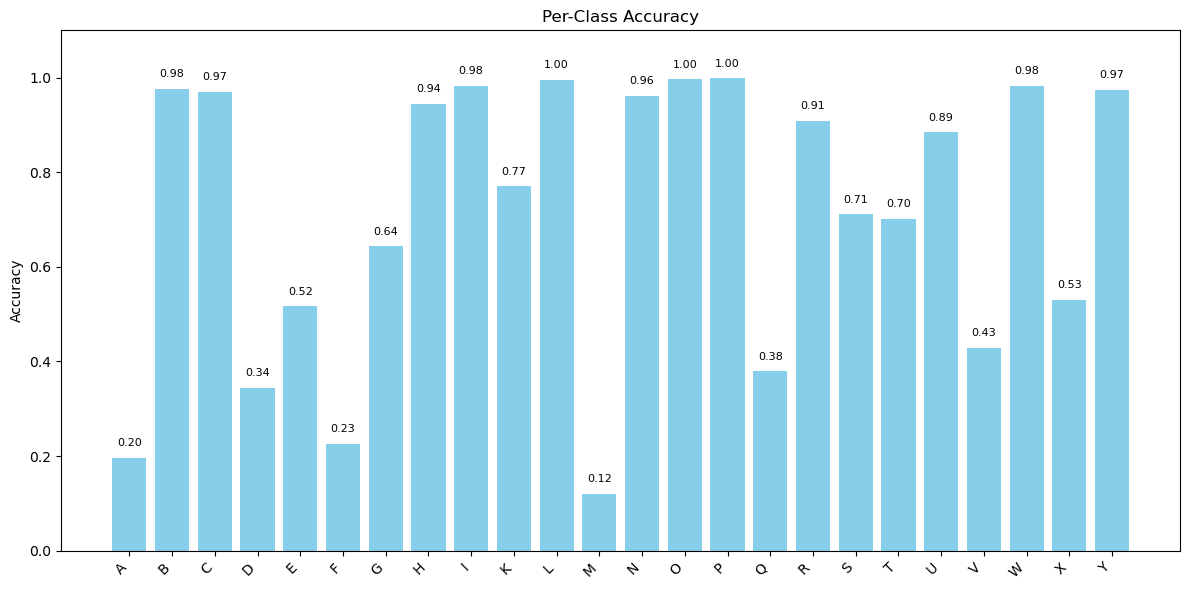

Test Loss: 2.5587, Test Accuracy: 0.7145


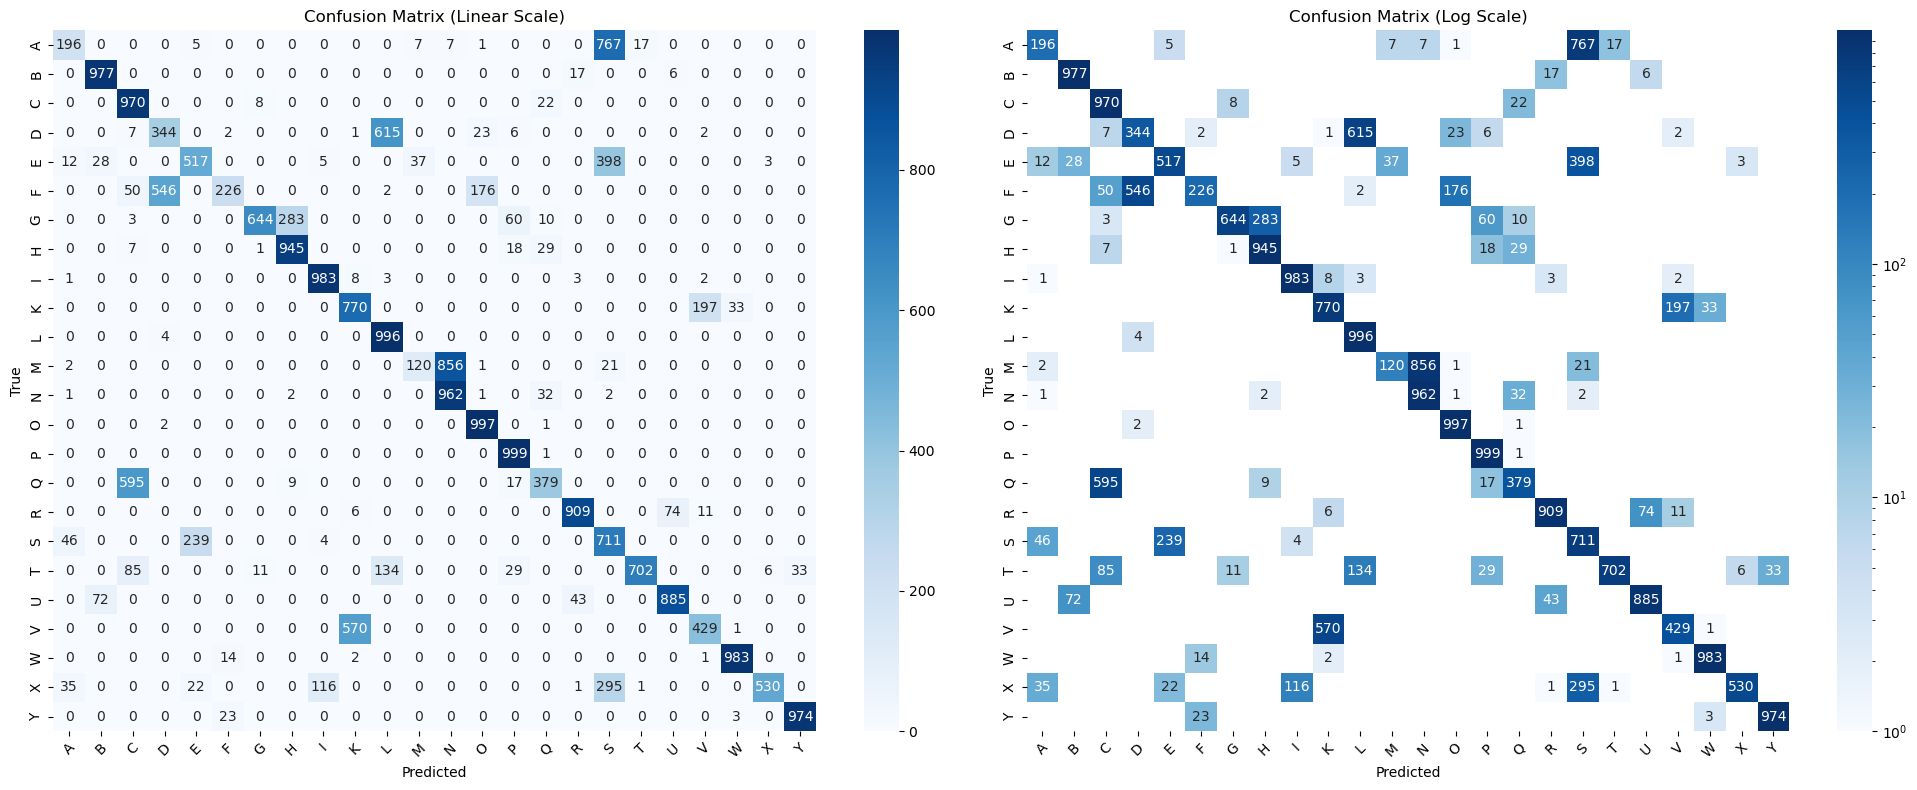


Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.20      0.30      1000
           1       0.91      0.98      0.94      1000
           2       0.56      0.97      0.71      1000
           3       0.38      0.34      0.36      1000
           4       0.66      0.52      0.58      1000
           5       0.85      0.23      0.36      1000
           6       0.97      0.64      0.77      1000
           7       0.76      0.94      0.84      1000
           8       0.89      0.98      0.93      1000
           9       0.57      0.77      0.65      1000
          10       0.57      1.00      0.72      1000
          11       0.73      0.12      0.21      1000
          12       0.53      0.96      0.68      1000
          13       0.83      1.00      0.91      1000
          14       0.88      1.00      0.94      1000
          15       0.80      0.38      0.51      1000
          16       0.93      0.91      0.92      1000
  

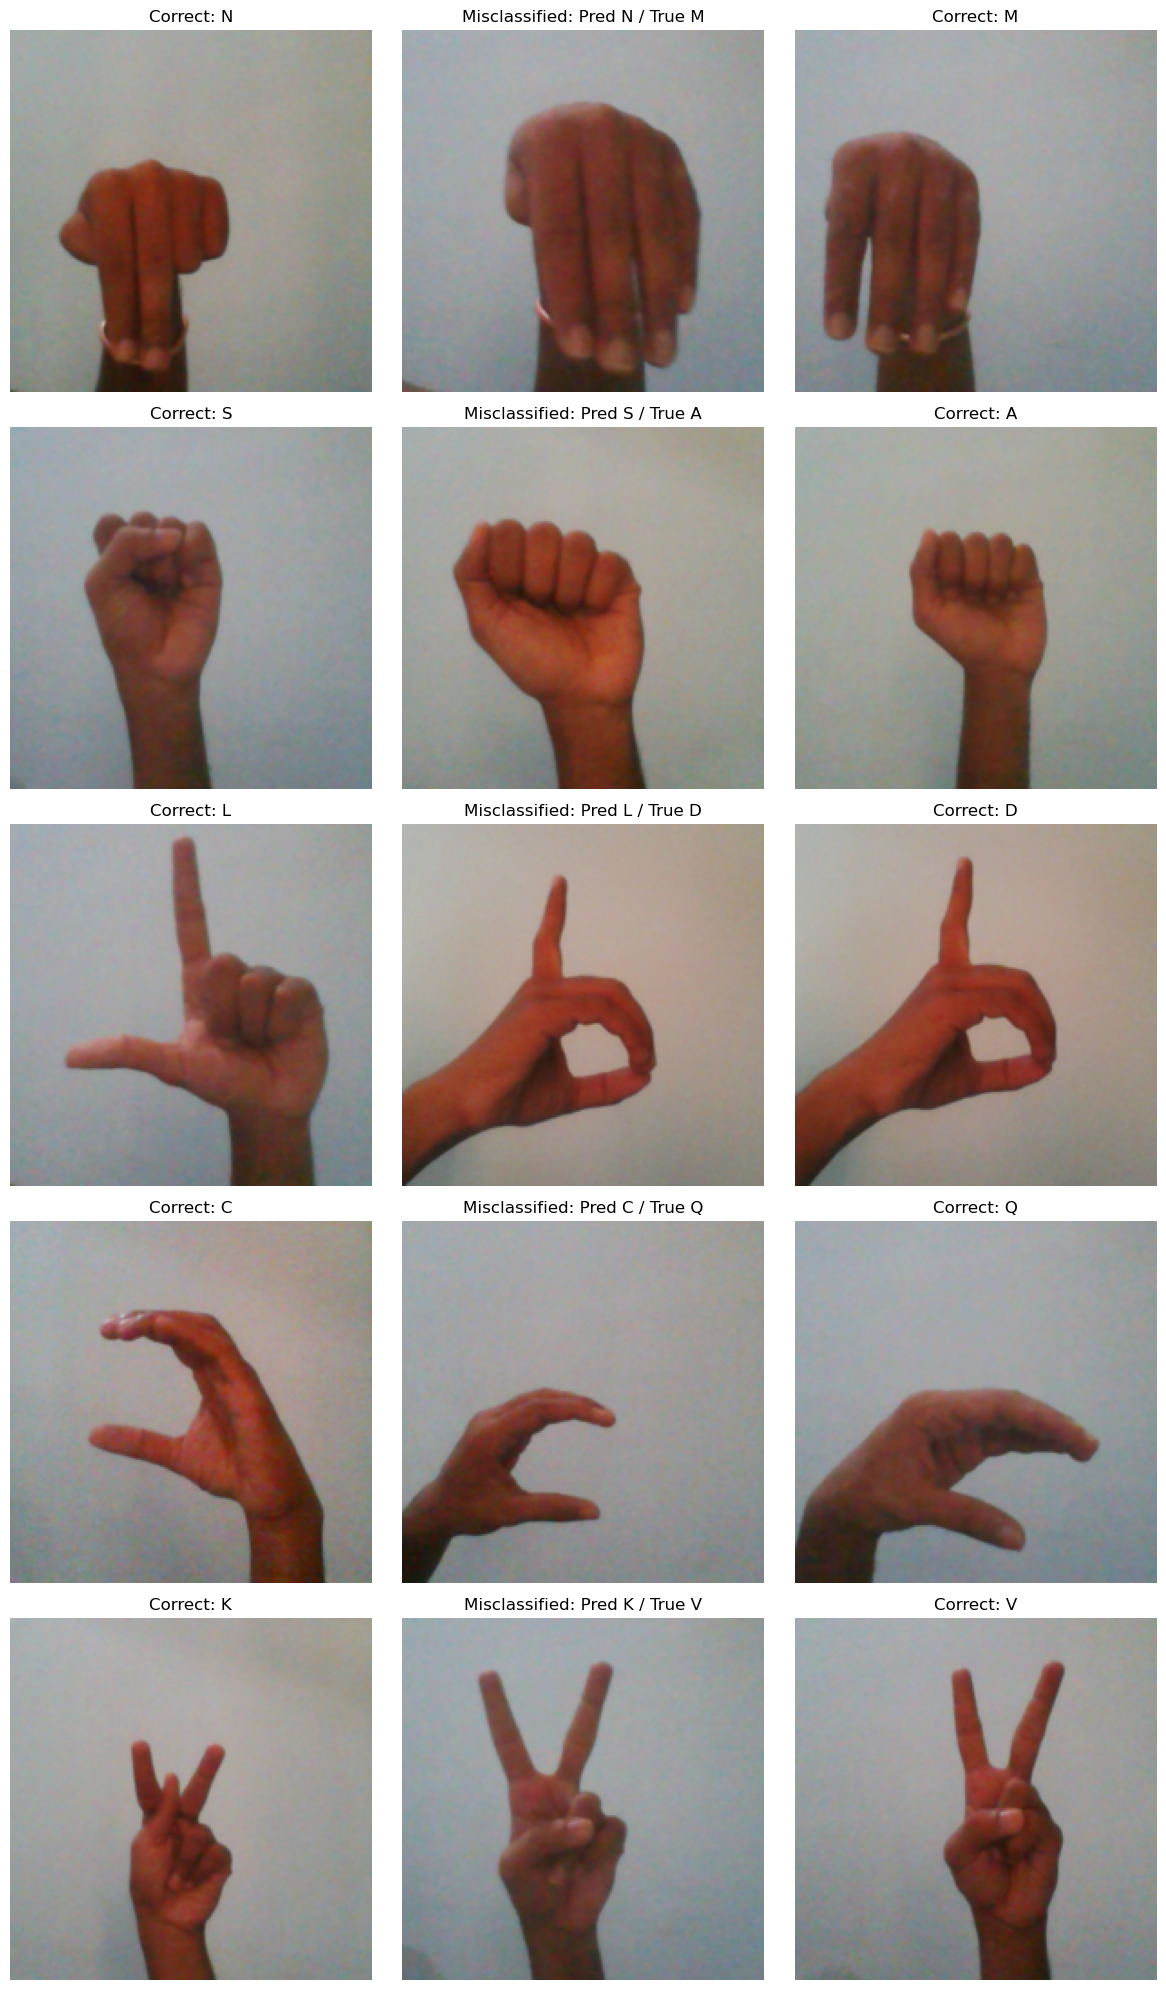

In [466]:
class_names = new_dataset.classes
model.load_state_dict(torch.load("best_model.pth"))

# Step 2: Load the saved model weights
model.load_state_dict(torch.load("best_model.pth", map_location=device))

# Evaluate the model on the test set
test_loss, test_acc, preds, labels, outputs, inputs = evaluate(model, new_loader, criterion, return_preds=True)

plot_per_class_accuracy(preds, labels, class_names)

# Print the results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Plot confusion matrix
cm = get_confusion_matrix(preds, labels, class_names)
plot_confusion_matrices(cm, class_names, normalize=False)

# Evaluate Precision, Recall, F1
evaluate_precision_recall_f1(preds, labels, num_classes=len(class_names))

# Assume that `preds`, `labels`, and `inputs` are the predictions, true labels, and inputs from the test set.
# Step 1: Track misclassified images
misclassified = [x for x in inputs if x['true_label'] != x['predicted_label']]

# Step 2: Get the top-n most misclassified pairs (based on frequency)
top_n_pairs = get_top_n_misclassified_pairs(misclassified, top_n=5)

# Step 3: Prepare a list of all images to find correctly classified examples
all_images = inputs

# Step 4: Plot top-n misclassified vs correct examples
plot_misclassified_vs_correct(top_n_pairs, misclassified, all_images, class_names, n=5)

## Experiment 2: Ablation Study